In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import methods
import pymaster as nmt
from importlib import reload

/tmp/ipykernel_46083/406365920.py:15: RuntimeWarning: invalid value encountered in true_divide
  input_cl /= ell_input*(ell_input+1)/2/np.pi


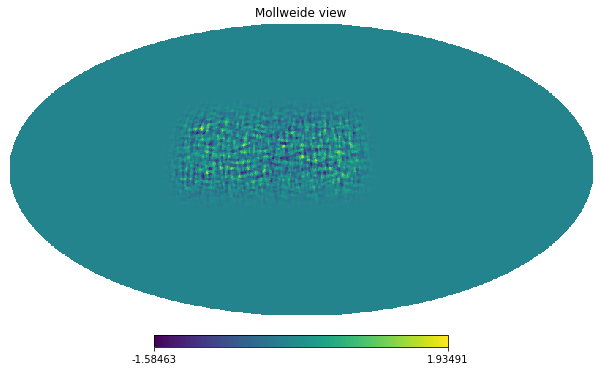

In [2]:
reload(methods)
ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)

nside = 128
lmax = 3*nside-1
npix = 12*nside**2
sigmab = hp.nside2resol(nside)
fwhm = (8*np.log(2))**0.5 * sigmab
pixels = methods.create_pixels()
bl = methods.get_bl(nside)
b = nmt.NmtBin.from_nside_linear(nside, 16)
ells = b.get_effective_ells()

input_cl = np.array([TT, EE, BB, TE])
input_cl /= ell_input*(ell_input+1)/2/np.pi 
for c in input_cl: c[0] = 0
input_cl = input_cl[:,:lmax+1]
ell_input = ell_input[:lmax+1]
    
input_cl = np.array([np.zeros(lmax+1), input_cl[1], np.zeros(lmax+1), np.zeros(lmax+1)]) #EE only
# input_cl = np.array([np.zeros(lmax+1), np.zeros(lmax+1), input_cl[2], np.zeros(lmax+1)]) #lensed r=0.1

input_map = hp.synfast(input_cl, nside, sigma=sigmab, new=True)

mask = np.zeros(npix)
mask[pixels[0]] = 1
mask_apo = nmt.mask_apodization(mask, 5, apotype="Smooth") 
mll = methods.get_mll(mask_apo, nside)
hp.mollview(mask_apo * input_map[1])

In [3]:
def run_sim(nside, mask_apo, b, fl=None, leakage=None, pure_b=True, replace=False, nsims=10, map_seed_start=123):
    w = nmt.NmtWorkspace()
    bl = methods.get_bl(nside)
    sigmab = hp.nside2resol(nside)
    ells = b.get_effective_ells()

    f = nmt.NmtField(mask_apo, [np.empty(12*nside**2), np.empty(12*nside**2)], beam=bl, purify_b=pure_b)
    w.compute_coupling_matrix(f, f, b)
    mll = w.get_coupling_matrix()
    
    if fl is not None:
        fl4 = np.interp(np.arange(0,lmax+1, 0.25), np.arange(lmax+1), fl)
        w.update_coupling_matrix(mll * fl4)
    
    Cls = np.zeros((nsims, 4, len(ells)))
    
    for i in range(nsims):
        np.random.seed(map_seed_start + i)
        input_map = hp.synfast(input_cl, nside, sigma=sigmab, new=True)            
        coadd_map1, coadd_map2 = methods.coadd_split(input_map, pixels, n_obs=1, I_noise_params=None, P_noise_params=None, replace=replace)
        
        if combine is True:
            larger_fwhm = np.deg2rad(2) 
            lp_map = hp.smoothing(input_map, fwhm=larger_fwhm) 
            bl_low = hp.gauss_beam(fwhm=larger_fwhm, lmax=3*nside)
            coadd_map1, coadd_map2 = methods.coadd_split(lp_map, pixels, n_obs=1, I_noise_params=None, P_noise_params=None, replace=replace)
            lost_map1 = lp_map - coadd_map1
            lost_map2 = lp_map - coadd_map2
            
            alml1 = hp.almxfl(hp.map2alm(lost_map1), 1/bl_low)
            alml2 = hp.almxfl(hp.map2alm(lost_map2), 1/bl_low)
            
            alm1 = hp.map2alm(coadd_map1)
            alm2 = hp.map2alm(coadd_map2)
            
            coadd_map1 = hp.alm2map(alm1 + alml1)
            coadd_map2 = hp.alm2map(alm2 + alml2)
            
            
        f1 = nmt.NmtField(mask_apo, [coadd_map1[1], coadd_map2[2]], purify_b=pure_b)
        f2 = nmt.NmtField(mask_apo, [coadd_map2[1], coadd_map2[2]], purify_b=pure_b)

        Cls[i] = methods.compute_master(f1, f2, w, leakage)

    return np.mean(Cls, axis=0), np.std(Cls, axis=0)

In [4]:
reload(methods)
flat_cl = np.ones(lmax+1)
pcl = methods.sim_pcl(flat_cl, pixels, n_sims=32, n_obs=1, map_seed_start=1000)
fl = methods.get_fl(flat_cl, pcl, bl, mll, niter=3)

  0%|                                                    | 0/32 [00:00<?, ?it/s]/scratch/yuyang/destripe/methods.py:89: RuntimeWarning: invalid value encountered in true_divide
  output_map = PT(filtered_tod, pixels, npix)/PTP(pixels, npix)
100%|███████████████████████████████████████████| 32/32 [00:20<00:00,  1.58it/s]


(2.0, 256.0)

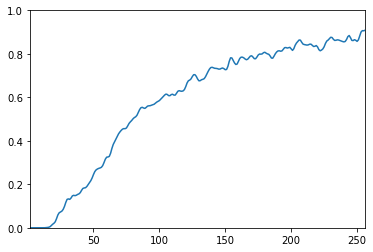

In [5]:
plt.plot(fl)
plt.ylim([0, 1])
plt.xlim([2, 2*nside])

In [6]:
reload(methods)
pcl4 = methods.sim_pcl(input_cl, pixels, n_sims=32, n_obs=1, map_seed_start=2000)

IQU mode


  0%|                                                    | 0/32 [00:00<?, ?it/s]/scratch/yuyang/destripe/methods.py:89: RuntimeWarning: invalid value encountered in true_divide
  output_map = PT(filtered_tod, pixels, npix)/PTP(pixels, npix)
100%|███████████████████████████████████████████| 32/32 [00:56<00:00,  1.77s/it]


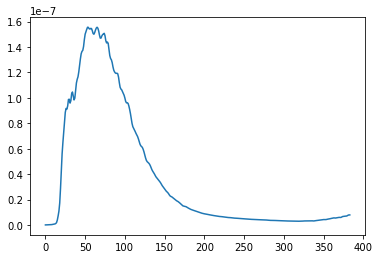

In [7]:
leakage = pcl4[2] 
plt.plot(leakage)

In [8]:
reload(methods)
mean, std = run_sim(nside, mask_apo, b, fl=fl, leakage=None, pure_b=False, nsims=10)
mean_p, std_p = run_sim(nside, mask_apo, b, fl=fl, leakage=None, pure_b=True, nsims=10)
mean_r, std_r = run_sim(nside, mask_apo, b, fl=None, pure_b=True, nsims=10, replace=True)

/scratch/yuyang/destripe/methods.py:89: RuntimeWarning: invalid value encountered in true_divide
  output_map = PT(filtered_tod, pixels, npix)/PTP(pixels, npix)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


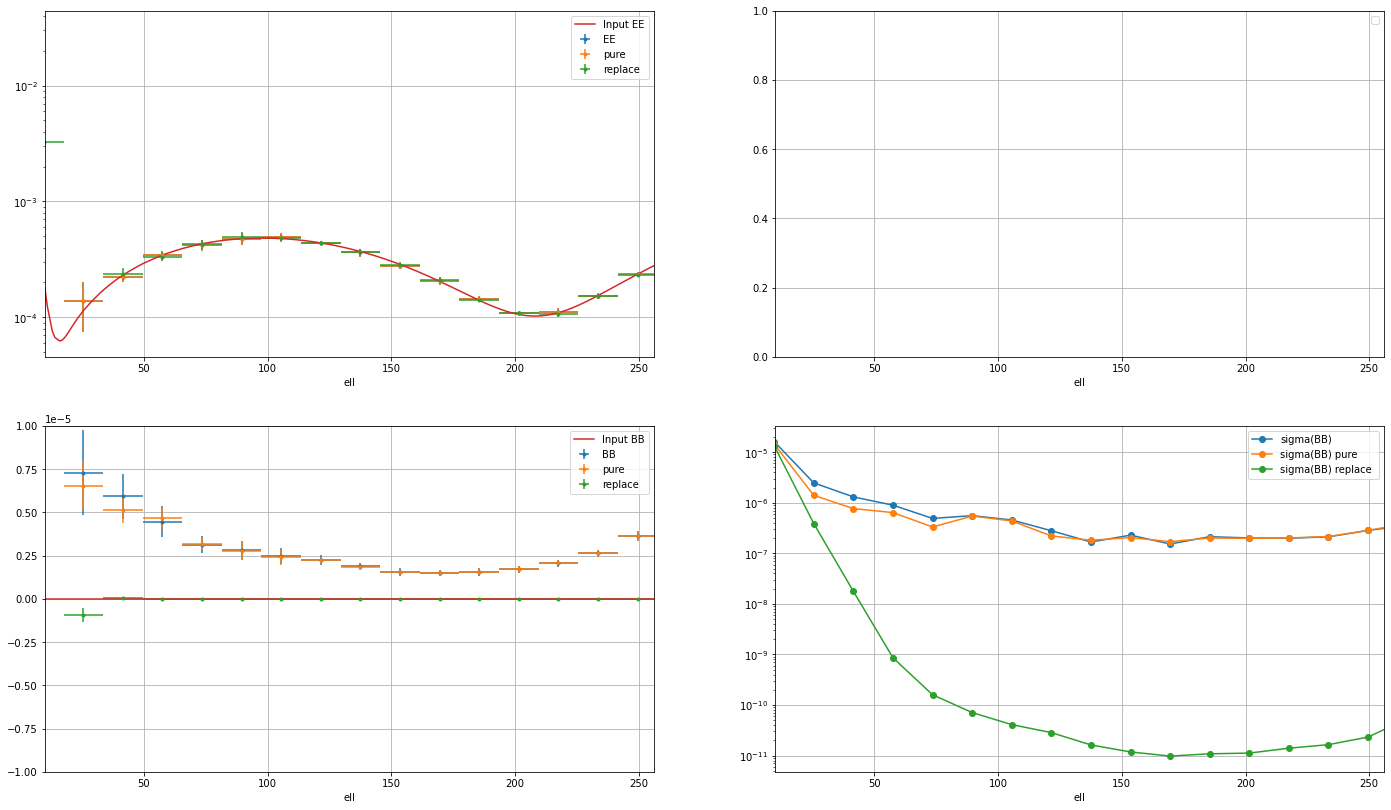

In [9]:
bin_width=np.median(np.diff(ells))/2
fig, axes = plt.subplots(2,2, figsize=(24, 14))

axes[0][0].errorbar(ells, mean[0], yerr=std[0], xerr=bin_width, fmt='.', label='EE')
axes[0][0].errorbar(ells, mean_p[0], yerr=std_p[0], xerr=bin_width, fmt='.', label='pure')
axes[0][0].errorbar(ells, mean_r[0], yerr=std_r[0], xerr=bin_width, fmt='.', label='replace')
axes[0][0].plot(ell_input, input_cl[1], label='Input EE')
axes[0][0].semilogy()

# axes[0][1].errorbar(ells, fb_mean[3], yerr=fb_std[3], xerr=bin_width, fmt='.', label='BB')
# axes[0][1].plot(ell_input, input_cl[3], label='Input TE')

axes[1][0].errorbar(ells, mean[3], std[3], bin_width, fmt='.', label='BB')
axes[1][0].errorbar(ells, mean_p[3], std_p[3], bin_width, fmt='.', label='pure')
axes[1][0].errorbar(ells, mean_r[3], std_r[3], bin_width, fmt='.', label='replace')
axes[1][0].plot(ell_input, input_cl[2], label='Input BB')
# axes[1][0].loglog()

axes[1][0].set_ylim([-1e-5, 1e-5])

axes[1][1].plot(ells, std[3], label='sigma(BB)', marker='o')
axes[1][1].plot(ells, std_p[3], label='sigma(BB) pure ', marker='o')
axes[1][1].plot(ells, std_r[3], label='sigma(BB) replace ',marker='o')

axes[1][1].semilogy()

for ax in axes.flatten():
    ax.set_xlabel('ell')
    ax.legend()
    ax.grid()  
    ax.set_xlim([10,2*nside])